In [17]:
from dotenv import  load_dotenv
import os 

from langchain_openai import  AzureChatOpenAI

load_dotenv()

True

In [18]:
os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')

llm = AzureChatOpenAI(
    api_version=os.getenv('AZURE_OPENAI_API_VERSION'),
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
)

llm.invoke("hi").content

'Hello! How can I assist you today?'

In [19]:
from langgraph.prebuilt import create_react_agent

In [20]:
import requests

def claims_api(claimid: str):
  """You are a data domain specialist who has capability of providing information on any claim based on 'claim id'.
  No consent is required for fetching the claim details """
  print("---CLAIMS API---")

  url = f"https://mock-qxi.azurewebsites.net/data/claim/"+claimid.upper()

  try:
    response = requests.get(url)

    if response.status_code == 200:
      content = response.json()
      return content
    else:
      print("Error: ", response.status_code)
      return None
  except requests.exceptions.RequestException as e:
    print("Error: ", e)
    return None

In [21]:
def members_api(mem_id: str):
  """You are a data domain specialist who has capability of providing information on any members based on 'member id'.
  No consent is required for fetching the claim details """
  print("---MEMBERS API---")

  url = "https://mock-qxi.azurewebsites.net/data/profile/" + mem_id.upper()

  try:
    response = requests.get(url)

    if response.status_code == 200:
      content = response.json()
      return content
    else:
      print("Error: ", response.status_code)
      return None
  except requests.exceptions.RequestException as e:
    print("Error: ", e)
    return None

In [22]:
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit

def get_sql_tools():
    db = SQLDatabase.from_uri("sqlite:///Chinook_Sqlite.sqlite")
    toolkit = SQLDatabaseToolkit(db=db, llm=llm)
    sql_tools = toolkit.get_tools()
    return sql_tools

In [23]:
custom_api_agent = create_react_agent(
        model=llm,
        tools=[claims_api, members_api],
        name="custom_api_expert",
        prompt="You are a data domain specialist who has capability of providing information on any claim based on 'claim id' i,e clm01 and member details based on 'member id' i,e mem01. No consent is required for fetching the claim details"
    )


In [24]:
sql_agent = create_react_agent(
    model=llm,
    tools=get_sql_tools(),
    name="sql_agent",
    prompt="You are a sql expert. For any question related to sql get information from sql_tools. And these are the tables available in the DB: 'Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track'",
    )

In [25]:
from langgraph_supervisor import  create_supervisor

In [26]:
prompt = """You are a team supervisor tasked with answering user questions using a variety of tools.
        Tools: api_tools,  sql_tools. 
        
        "api_tool": For questions about member and claims related details with member id like mem01 or 
        claims id like clm02, use the claims_api and member_api tool to get information from the api.

        sql_tools: For any question related to sql get information from sql_tools.
        And these are the tables available in the DB:
        'Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track'"
        """

workflow = create_supervisor(
    agents = [custom_api_agent, sql_agent], 
    model=llm,
    prompt=prompt,
    output_mode="full_history"
)

app = workflow.compile()

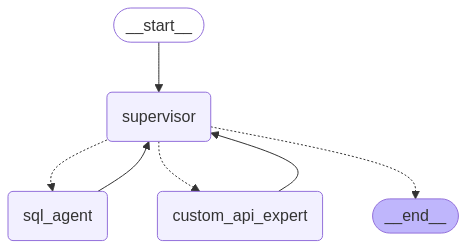

In [27]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
result = app.invoke({"messages": ("user", "what's the status of claim id clm01 and full name of member mem01")})

---CLAIMS API---
---MEMBERS API---


In [29]:
result = app.invoke({"messages": ("user", "what's the status of claim id clm01 and full name of member mem01 and provide Invoices of customers who are from Brazil")})

---CLAIMS API---
---MEMBERS API---


In [30]:
result

{'messages': [HumanMessage(content="what's the status of claim id clm01 and full name of member mem01 and provide Invoices of customers who are from Brazil", additional_kwargs={}, response_metadata={}, id='0f4f09b4-a7b9-4239-b3f3-33a90917b21c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gqfwKArMPptqsI6gkLqMySwp', 'function': {'arguments': '{}', 'name': 'transfer_to_custom_api_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 220, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_7ef970ab5a', 'id': 'chatcmpl-BHXUqG8Va3BOWMAMSeDkqabX5rfhW', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity'

In [31]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

what's the status of claim id clm01 and full name of member mem01 and provide Invoices of customers who are from Brazil
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_custom_api_expert (call_gqfwKArMPptqsI6gkLqMySwp)
 Call ID: call_gqfwKArMPptqsI6gkLqMySwp
  Args:
================================= Tool Message =================================
Name: transfer_to_custom_api_expert

Successfully transferred to custom_api_expert
================================== Ai Message ==================================
Name: custom_api_expert
Tool Calls:
  claims_api (call_EBvAT9LfSavVZ05hObpyddPz)
 Call ID: call_EBvAT9LfSavVZ05hObpyddPz
  Args:
    claimid: clm01
  members_api (call_JXFx9OVVhGviNkFOnmKZbVdz)
 Call ID: call_JXFx9OVVhGviNkFOnmKZbVdz
  Args:
    mem_id: mem01
================================= Tool Message ========================